<a href="https://colab.research.google.com/github/windaapriliyanti/Myskill/blob/main/deep_learning_for_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2><center>Deep Learning for Time Series Forecasting</center></h2>


### comparison different approach in time series.

#### Content:
* [Time series visualization with matplotlib/seaborn](#Basic-EDA).
* [How to transform a time series dataset into a supervised learning problem](#Transform-the-data-into-a-time-series-problem).
* [How to develop a Multilayer Perceptron model for a univariate time series forecasting problem](#MLP-for-Time-Series-Forecasting).
* [How to develop a Convolutional Neural Network model for a univariate time series forecasting problem](#CNN-for-Time-Series-Forecasting).
* [How to develop a Long Short-Term Memory network model for a univariate time series forecasting problem](#LSTM-for-Time-Series-Forecasting).
* [How to develop a Hybrid CNN-LSTM model for a univariate time series forecasting problem](#CNN-LSTM-for-Time-Series-Forecasting).


#### Dependencies

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import  iplot
# Import the necessaries libraries
import plotly.offline as pyo
# Set notebook mode to work in offline
pyo.init_notebook_mode()
import plotly.io as pio
pio.renderers.default = 'iframe'
%matplotlib inline
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
# from tensorflow import set_random_seed
from numpy.random import seed
# set_random_seed(1)
seed(1)

### Loading data

In [ ]:
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

### Train set

In [ ]:
train.describe()

,store,item,sales
count,391472.000000,391472.000000,391472.000000
mean,5.443122,11.225130,53.874252
std,2.875697,6.192098,29.474032
min,1.000000,1.000000,0.000000
25%,3.000000,6.000000,31.000000
50%,5.000000,11.000000,49.000000
75%,8.000000,17.000000,72.000000
max,10.000000,22.000000,231.000000


In [ ]:
train.head()

,date,store,item,sales
0,2013-01-01,1.0,1.0,13.0
1,2013-01-02,1.0,1.0,11.0
2,2013-01-03,1.0,1.0,14.0
3,2013-01-04,1.0,1.0,13.0
4,2013-01-05,1.0,1.0,10.0


### Time period of the train dataset

In [ ]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


#### Let's find out what's the time gap between the last day from training set from the last day of the test set, this will be out lag (the amount of day that need to be forecast)

In [ ]:
lag_size = (test['date'].max().date() - train['date'].max().date()).days
print('Max date from train set: %s' % train['date'].max().date())
print('Max date from test set: %s' % test['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2017-12-31
Max date from test set: 2018-03-31
Forecast lag size 90


### EDA

To explore the time series data first we need to aggregate the sales by day

In [ ]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

### Overall daily sales

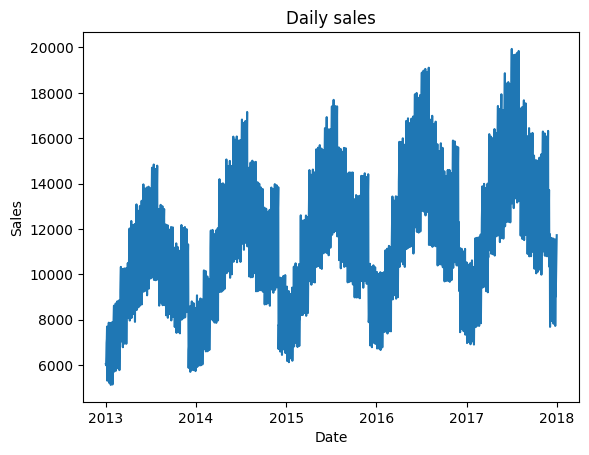

In [ ]:
import matplotlib.pyplot as plt

plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title('Daily sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


### Daily sales by store

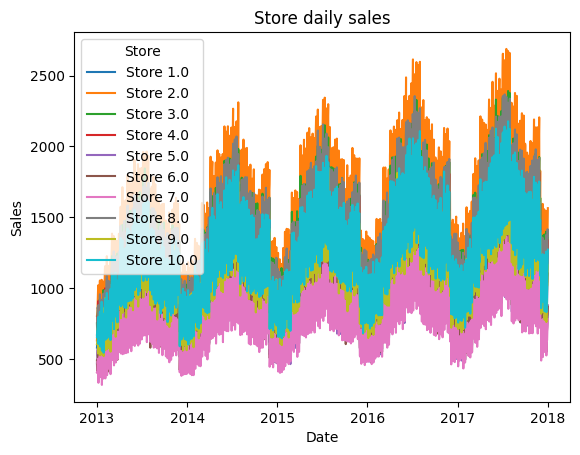

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

store_daily_sales_sc = []

for store in store_daily_sales['store'].unique():
    current_store_daily_sales = store_daily_sales[store_daily_sales['store'] == store]
    sns.lineplot(x='date', y='sales', data=current_store_daily_sales, label=f'Store {store}')

plt.title('Store daily sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(title='Store')
plt.show()


### Daily sales by item

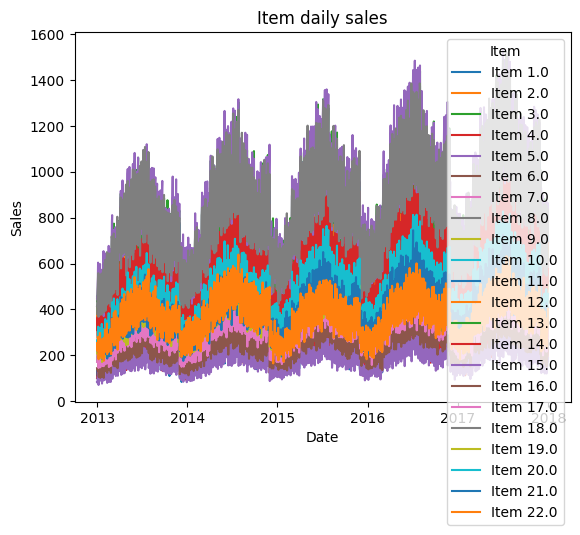

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

item_daily_sales_sc = []

for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[item_daily_sales['item'] == item]
    sns.lineplot(x='date', y='sales', data=current_item_daily_sales, label=f'Item {item}')

plt.title('Item daily sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(title='Item')
plt.show()


#### Sub-sample train set to get only the last year of data and reduce training time

In [ ]:
train = train[(train['date'] >= '2017-01-01')]

### Rearrange dataset so we can apply shift methods

In [ ]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1.0,1.0,2017-01-01,19.0
1,1.0,1.0,2017-01-02,15.0
2,1.0,1.0,2017-01-03,10.0
3,1.0,1.0,2017-01-04,16.0
4,1.0,1.0,2017-01-05,14.0


### Transform the data into a time series problem

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols = []
    names = []
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


#### We will use the current timestep and the last 29 to forecast 90 days ahead

In [ ]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,...,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1.0,1.0,33.0
30,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,...,24.0,1.0,1.0,9.0,1.0,1.0,17.0,1.0,1.0,15.0
31,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,...,9.0,1.0,1.0,17.0,1.0,1.0,15.0,1.0,1.0,21.0
32,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,...,17.0,1.0,1.0,15.0,1.0,1.0,17.0,1.0,1.0,29.0
33,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,...,15.0,1.0,1.0,17.0,1.0,1.0,24.0,1.0,1.0,19.0


#### Drop rows with different item or store values than the shifted columns

In [ ]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

#### Remove unwanted columns

In [ ]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

### Train/validation split

In [ ]:
# Label
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (43088, 30)
Validation set shape (28726, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
62536,113.0,113.0,132.0,127.0,118.0,135.0,165.0,114.0,107.0,121.0,...,153.0,101.0,89.0,108.0,130.0,115.0,154.0,143.0,86.0,138.0
22182,54.0,61.0,64.0,67.0,69.0,69.0,78.0,48.0,60.0,64.0,...,70.0,44.0,51.0,55.0,47.0,46.0,72.0,77.0,40.0,47.0
45473,90.0,76.0,102.0,88.0,82.0,113.0,77.0,66.0,93.0,87.0,...,64.0,90.0,94.0,89.0,101.0,103.0,112.0,69.0,62.0,77.0
33357,94.0,95.0,111.0,101.0,106.0,122.0,140.0,85.0,121.0,113.0,...,154.0,84.0,97.0,103.0,110.0,115.0,122.0,153.0,96.0,119.0
66825,19.0,43.0,32.0,41.0,36.0,56.0,38.0,23.0,22.0,33.0,...,33.0,31.0,23.0,36.0,25.0,31.0,33.0,34.0,31.0,37.0


### MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

In [ ]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3100      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
1347/1347 - 3s - loss: 533.8462 - val_loss: 429.3281 - 3s/epoch - 2ms/step
Epoch 2/40
1347/1347 - 3s - loss: 417.4918 - val_loss: 412.9243 - 3s/epoch - 2ms/step
Epoch 3/40
1347/1347 - 3s - loss: 402.0394 - val_loss: 391.1835 - 3s/epoch - 2ms/step
Epoch 4/40
1347/1347 - 3s - loss: 389.1859 - val_loss: 398.8632 - 3s/epoch - 2ms/step
Epoch 5/40
1347/1347 - 3s - loss: 381.2098 - val_loss: 421.0161 - 3s/epoch - 2ms/step
Epoch 6/40
1347/1347 - 3s - loss: 376.3452 - val_loss: 371.8275 - 3s/epoch - 2ms/step
Epoch 7/40
1347/1347 - 3s - loss: 372.4084 - val_loss: 372.1110 - 3s/epoch - 2ms/step
Epoch 8/40
1347/1347 - 3s - loss: 370.7762 - val_loss: 382.9834 - 3s/epoch - 2ms/step
Epoch 9/40
1347/1347 - 2s - loss: 371.3307 - val_loss: 366.7720 - 2s/epoch - 1ms/step
Epoch 10/40
1347/1347 - 3s - loss: 369.6920 - val_loss: 372.7148 - 3s/epoch - 2ms/step
Epoch 11/40
1347/1347 - 3s - loss: 370.9799 - val_loss: 365.7173 - 3s/epoch - 2ms/step
Epoch 12/40
1347/1347 - 3s - loss: 367.0167 - val_lo

In [ ]:
prediction = model_mlp.predict(X_valid)

898/898 [==============================] - 1s 886us/step


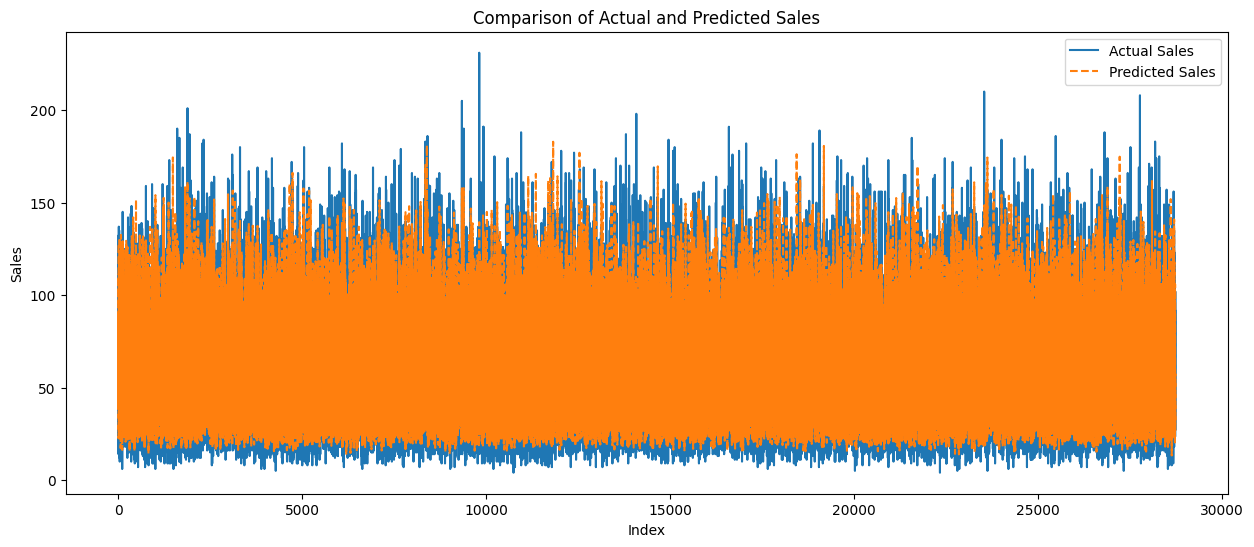

In [ ]:
# Plot the actual sales
# Assuming predictions and Y_valid are numpy arrays or pandas Series
index = np.arange(len(Y_valid))
plt.figure(figsize=(15, 6))
plt.plot(index, Y_valid, label='Actual Sales')
plt.plot(index, prediction, label='Predicted Sales', linestyle='--')


plt.title('Comparison of Actual and Predicted Sales')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.legend()

### CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (43088, 30, 1)
Validation set shape (28726, 30, 1)


In [ ]:
import tensorflow as tf

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 29, 64)            192       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 14, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 896)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                44850     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 45093 (176.14 KB)
Trainable params: 45093 (176.14 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
1347/1347 - 4s - loss: 449.8357 - val_loss: 413.3824 - 4s/epoch - 3ms/step
Epoch 2/40
1347/1347 - 5s - loss: 416.3279 - val_loss: 408.8818 - 5s/epoch - 4ms/step
Epoch 3/40
1347/1347 - 5s - loss: 410.5094 - val_loss: 396.7835 - 5s/epoch - 4ms/step
Epoch 4/40
1347/1347 - 3s - loss: 400.8997 - val_loss: 405.6018 - 3s/epoch - 2ms/step
Epoch 5/40
1347/1347 - 3s - loss: 391.5092 - val_loss: 393.8925 - 3s/epoch - 3ms/step
Epoch 6/40
1347/1347 - 3s - loss: 385.7232 - val_loss: 383.6086 - 3s/epoch - 3ms/step
Epoch 7/40
1347/1347 - 4s - loss: 381.5965 - val_loss: 377.4089 - 4s/epoch - 3ms/step
Epoch 8/40
1347/1347 - 3s - loss: 377.3817 - val_loss: 374.6593 - 3s/epoch - 3ms/step
Epoch 9/40
1347/1347 - 3s - loss: 375.8908 - val_loss: 381.1366 - 3s/epoch - 3ms/step
Epoch 10/40
1347/1347 - 4s - loss: 373.6162 - val_loss: 372.2060 - 4s/epoch - 3ms/step
Epoch 11/40
1347/1347 - 3s - loss: 373.2550 - val_loss: 372.3434 - 3s/epoch - 3ms/step
Epoch 12/40
1347/1347 - 3s - loss: 371.3409 - val_lo

### LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
1347/1347 - 15s - loss: 633.9942 - val_loss: 419.3528 - 15s/epoch - 11ms/step
Epoch 2/40
1347/1347 - 13s - loss: 392.8367 - val_loss: 382.3685 - 13s/epoch - 10ms/step
Epoch 3/40
1347/1347 - 13s - loss: 390.1471 - val_loss: 388.7083 - 13s/epoch - 10ms/step
Epoch 4/40
1347/1347 - 13s - loss: 380.9984 - val_loss: 371.9055 - 13s/epoch - 10ms/step
Epoch 5/40
1347/1347 - 13s - loss: 378.1608 - val_loss: 387.7960 - 13s/epoch - 10ms/step
Epoch 6/40
1347/1347 - 13s - loss: 381.1974 - val_loss: 377.3741 - 13s/epoch - 10ms/step
Epoch 7/40
1347/1347 - 13s - loss: 380.1581 - val_loss: 385.3736 - 13s/epoch - 10ms/step
Epoch 8/40
1347/1347 - 13s - loss: 382.5581 - val_loss: 373.9300 - 13s/epoch - 10ms/step
Epoch 9/40
1347/1347 - 13s - loss: 375.4222 - val_loss: 397.5273 - 13s/epoch - 10ms/step
Epoch 10/40
1347/1347 - 13s - loss: 415.3538 - val_loss: 425.1757 - 13s/epoch - 10ms/step
Epoch 11/40
1347/1347 - 13s - loss: 395.0381 - val_loss: 396.4755 - 13s/epoch - 10ms/step
Epoch 12/40
1347/13

### CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
>Manfaat model ini ialah model ini dapat menyokong rangkaian input yang sangat panjang yang boleh dibaca sebagai blok atau sub-rangkaian oleh model CNN, kemudian disusun semula oleh model LSTM.
>
>Apabila menggunakan model hibrida CNN-LSTM, kita akan memecahkan setiap sampel kepada sub-rangkaian yang lebih kecil. Model CNN akan menafsirkan setiap sub-rangkaian dan LSTM akan menyusun semula interpretasi dari sub-rangkaian tersebut. Oleh itu, kita akan memecah setiap sampel kepada 2 sub-rangkaian sebanyak 2 kali setiap sub-rangkaian.
>
>CNN akan ditakrifkan untuk mengharapkan 2 timestamp per sub-rangkaian dengan satu features. Keseluruhan model CNN kemudian dibungkus dengan lapisan pembungkus TimeDistributed supaya ia boleh digunakan pada setiap sub-rangkaian dalam sampel. Hasilnya kemudian diinterpretasi oleh lapisan LSTM sebelum model mengeluarkan ramalan.

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

In [ ]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (43088, 2, 15, 1)
Validation set shape (28726, 2, 15, 1)


In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
1347/1347 - 7s - loss: 472.7790 - val_loss: 454.9452 - 7s/epoch - 5ms/step
Epoch 2/40
1347/1347 - 7s - loss: 445.3832 - val_loss: 437.8987 - 7s/epoch - 5ms/step
Epoch 3/40
1347/1347 - 6s - loss: 436.3118 - val_loss: 441.7041 - 6s/epoch - 4ms/step
Epoch 4/40
1347/1347 - 6s - loss: 433.7401 - val_loss: 434.7228 - 6s/epoch - 5ms/step
Epoch 5/40
1347/1347 - 5s - loss: 432.3226 - val_loss: 441.4760 - 5s/epoch - 4ms/step
Epoch 6/40
1347/1347 - 6s - loss: 432.3069 - val_loss: 443.2961 - 6s/epoch - 5ms/step
Epoch 7/40
1347/1347 - 6s - loss: 430.8320 - val_loss: 432.1779 - 6s/epoch - 4ms/step
Epoch 8/40
1347/1347 - 7s - loss: 428.9930 - val_loss: 431.5882 - 7s/epoch - 5ms/step
Epoch 9/40
1347/1347 - 6s - loss: 427.1580 - val_loss: 429.4678 - 6s/epoch - 4ms/step
Epoch 10/40
1347/1347 - 6s - loss: 423.5712 - val_loss: 423.8629 - 6s/epoch - 5ms/step
Epoch 11/40
1347/1347 - 6s - loss: 422.4684 - val_loss: 421.7371 - 6s/epoch - 4ms/step
Epoch 12/40
1347/1347 - 8s - loss: 419.5556 - val_lo

### Comparing models

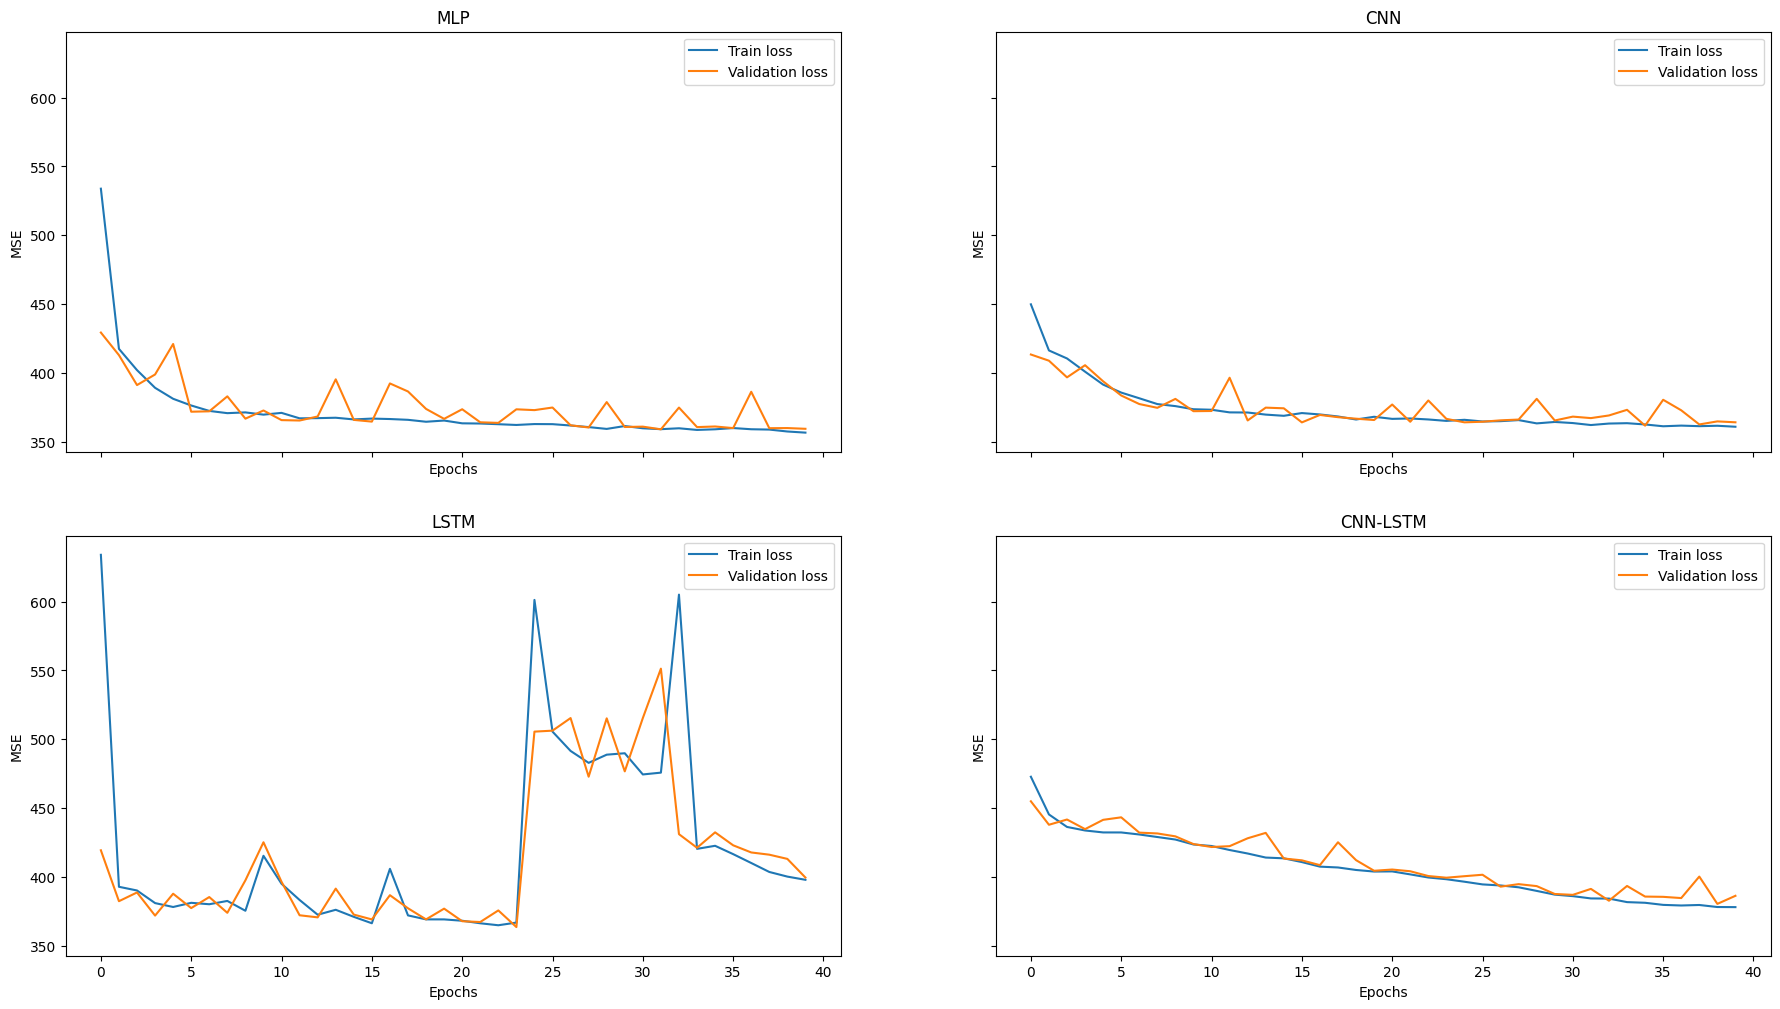

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

#### MLP on train and validation

In [ ]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

898/898 [==============================] - 1s 887us/step
Train rmse: 18.791619419701835
Validation rmse: 18.958199471690588


#### CNN on train and validation

In [ ]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

898/898 [==============================] - 1s 1ms/step
Train rmse: 18.826546476352025
Validation rmse: 19.082290639453095


#### LSTM on train and validation

In [ ]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

898/898 [==============================] - 1s 1ms/step
Train rmse: 19.81190626917404
Validation rmse: 19.082290639453095


#### CNN-LSTM on train and validation

In [ ]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

898/898 [==============================] - 1s 2ms/step
Train rmse: 19.58978127051244
Validation rmse: 19.654088618104517
